<a href="https://colab.research.google.com/github/weedge/doraemon-nb/blob/main/redisxann_usearch_implement_approximate_query_for_molecular_geometries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run RedisxANN-usearch redis Server

In [ ]:
!rm -rf redis && git clone https://github.com/redis/redis && \
  cd redis && \
  git checkout 7.0 && \
  make REDIS_CFLAGS='-Werror' BUILD_TLS=yes && make install && \
  which redis-server && redis-server --version

In [ ]:
!git clone https://github.com/weedge/RedisXANN.git --recursive

In [ ]:
!curl https://sh.rustup.rs -sSf > rustup.sh

In [ ]:
!sh rustup.sh -y

In [ ]:
!cd RedisXANN && source "$HOME/.cargo/env" && \
  cargo clean && \
  cargo build --lib --manifest-path rust/usearch/Cargo.toml --release

In [9]:
!redis-server --daemonize yes \
  --loadmodule RedisXANN/target/release/libredisxann_usearch.so is_remove_serialized_file 1 \
  --port 6666 \
  --dbfilename dump.6666.rdb

In [11]:
!ps -ef | grep redis-server | grep -v grep

root       16209       1  0 03:19 ?        00:00:00 redis-server *:6666


# Data
1. https://pubchem.ncbi.nlm.nih.gov/
2. https://pubchem.ncbi.nlm.nih.gov/sources/
3. 生物分子数据：https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/
4. 说明：https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/README-Compound-SDF
5. 数据格式：https://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_sdtags.txt ， https://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_sdtags.pdf

本示例使用的测试数据为PubChem开源数据集，共计11012行数据，上述下载地址提供的数据为SMI格式，数据示例如下，两列分别为化学分子式和唯一ID。




In [ ]:
# 已经格式化为sim格式数据
!wget https://static-aliyun-doc.oss-cn-hangzhou.aliyuncs.com/file-manage-files/en-US/20230518/ypqh/Compound_168000001_168500000.smi -O oss_Compound_168000001_168500000.smi

In [33]:
# 格式： 分子式, CID(唯一的化合物 ID)
!head -n 10 oss_Compound_168000001_168500000.smi
!cat oss_Compound_168000001_168500000.smi | grep "smiles" | head

CCC1=CN=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1ccc(OC)cc1OC,168000001
CC(C)CN1C(=O)C2SCCC2N2C(=S)NNC12,168000002
CC1=C[NH+]=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1cccc(C(F)(F)F)c1,168000003
CC1=CN=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1cccc(C(F)(F)F)c1,168000004
CCCCC1NC(SCC(=O)NCc2ccco2)C2C(=O)N(C)C(=O)N(C)C2N1,168000005
COC(=O)c1ccc(CN2NC3N(CCN3c3ccccc3)C(=O)C2=O)o1,168000006
Cc1ccc(C2NC(SCCN3CCCC3)C3C(=O)N(C)C(=O)N(C)C3N2)cc1,168000007
O=C(Nc1ccccc1Cl)C1NNNC1c1ccccc1,168000008
CCOC(=O)N1CCC(NC(=O)CN2CCN(c3cc(C)cc(C)c3)C(=O)C2=O)CC1,168000009
O=C(Nc1ccccc1-c1cn2c(n1)CCCC2)C1CC(=O)N(c2ccccc2)C(=O)N1,168000010


In [ ]:
!pip install numpy matplotlib rdkit redisx

如果下载sdf文件，需要转换为sim格式：

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/Compound_168000001_168500000.sdf.gz -O Compound_168000001_168500000.sdf.gz\
  && rm -rf Compound_168000001_168500000.sdf && gunzip Compound_168000001_168500000.sdf.gz

In [34]:
# sdf文件格式：https://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_sdtags.pdf
!head -n 100 Compound_168000001_168500000.sdf
!tail -n 50 Compound_168000001_168500000.sdf
!cat Compound_168000001_168500000.sdf | grep "smiles" | head

168000001
  -OEChem-10062315042D

 49 51  0     1  0  0  0  0  0999 V2000
    7.1892    0.4628    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    8.9212   -2.5372    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    5.4639    2.4972    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.0000    2.5373    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    7.1892   -2.5372    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    8.0552   -1.0372    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    5.4292   -2.5719    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    5.4407    0.4974    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    6.3231   -1.0372    0.0000 C   0  0  3  0  0  0  0  0  0  0  0  0
    6.3231   -2.0372    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.4292   -0.5026    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.1892   -0.5372    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.5231   -1.0164    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    8.0552   -2.

In [14]:
import sys
from rdkit import Chem

def converter(file_name):
    mols = [mol for mol in Chem.SDMolSupplier(file_name)]
    outname = file_name.split(".sdf")[0] + ".smi"
    out_file = open(outname, "w")
    for mol in mols:
        smi = Chem.MolToSmiles(mol)
        name = mol.GetProp("_Name")
        out_file.write("{},{}\n".format(smi, name))
    out_file.close()


In [ ]:
converter("/content/Compound_168000001_168500000.sdf")

## Impl demo

In [28]:
import os
import sys

from redis import ResponseError
from rdkit.Chem import Draw, AllChem
from rdkit import DataStructs, Chem
from rdkit import RDLogger
from concurrent.futures import ThreadPoolExecutor
RDLogger.DisableLog('rdApp.*')


In [29]:
from random import random
from redisx.client import Client
import numpy as np


# change the following configuration for your redis.
REDIS_HOST = "localhost"
REDIS_PORT = 6666
REDIS_DB = 0
REDIS_USERNAME = ""
REDIS_PASSWORD = ""


def get_client() -> Client:
    return Client(
        host=REDIS_HOST,
        port=REDIS_PORT,
        db=REDIS_DB,
        username=REDIS_USERNAME,
        password=REDIS_PASSWORD,
    )


def get_random_vectors(dim: int, n: int):
    return [[(random()/100)-(random()/100) for _ in range(dim)] for _ in range(n)]


def get_numpy_random_vectors_f16(dim: int, n: int):
    #return np.random.default_rng().standard_normal(10, dtype=np.float32)
    return np.random.uniform(-0.1, 0.1, (n, dim)).astype(np.float16)



In [56]:
from typing import Union

from redis import ResponseError
from redisx.define import UsearchQuantizationType,DistanceMetric
from redisx.ann_usearch import VectorType

cli = get_client()

def create_index(index_name: str, dim:int):
    try:
        return cli.create_index(
            index_name, dim,
            metric=DistanceMetric.L2,
            quantization=UsearchQuantizationType.F32)
    except ResponseError as e:
        print(e)
        return None

def get_index(index_name: str):
    try:
        return cli.get_index(index_name)
    except ResponseError as e:
        print(e)
        return None

def delete_index(index_name: str):
    try:
        return cli.del_index(index_name)
    except ResponseError as e:
        print(e)
        return False

def add_vector(index_name: str, name: str, vector: Union[VectorType, str]):
    try:
        return cli.add_vector(index_name, name, vector)
    except ResponseError as e:
        print(e)
        return None

def get_vector(index_name: str, name: str):
    try:
        return cli.get_vector(index_name, name)
    except ResponseError as e:
        print(e)
        return None

def del_vector(index_name: str, name: str):
    try:
        return cli.del_vector(index_name, name)
    except ResponseError as e:
        print(e)
        return False

def kann_search(index_name: str, k: int, query_vector: Union[VectorType, str]):
    try:
        return cli.kann_search(index_name, k, query_vector)
    except ResponseError as e:
        print(e)
        return False

def test_search():
    dim = 1024
    print("delete_index res {}".format(delete_index("test_idx0")))
    print("create_index res {}".format(create_index("test_idx0", dim)))
    print("get_index res {}".format(get_index("test_idx0")))
    print("\n======= kann search =====\n")
    for i, vector in enumerate(get_random_vectors(dim, 10)):
        name = "n%i" % i
        print("add_vector {} {} res {}".format(
            name, vector[0:10], add_vector("test_idx0", name, vector)))
        # print("get_vector res {}".format(get_vector("test_idx0", name)))

    print("after add, get_index res {}".format(get_index("test_idx0")))
    k = 10
    for i, query_vector in enumerate(get_random_vectors(dim, 3)):
        print("{}. kann_search k {} query_vector {} res {}".format(
            i, k, query_vector[0:10],
            kann_search("test_idx0", k, query_vector)))

    print("delete_index res {}".format(delete_index("test_idx0")))

def test_search_f16():
    dim = 1024
    print("delete_index res {}".format(delete_index("test_idx0")))
    print("create_index res {}".format(create_index("test_idx0", dim)))
    print("get_index res {}".format(get_index("test_idx0")))
    print("\n======= kann search =====\n")
    for i, vector in enumerate(get_numpy_random_vectors_f16(dim, 10)):
        name = "n%i" % i
        print("add_vector {} {} res {}".format(
            name, vector[0:10], add_vector("test_idx0", name, vector)))
        print("get_vector res {}".format(get_vector("test_idx0", name)))

    print("after add, get_index res {}".format(get_index("test_idx0")))
    k = 10
    for i, query_vector in enumerate(get_numpy_random_vectors_f16(dim, 3)):
        print("{}. kann_search k {} query_vector {} res {}".format(
            i, k, query_vector[0:10],
            kann_search("test_idx0", k, query_vector)))

    print("delete_index res {}".format(delete_index("test_idx0")))

In [48]:
INDEX_NAME="MOLSEARCH_TEST"

In [57]:
def build_index():
    """
    创建用于存储分子结构的向量索引：
    * 本示例的索引名称为"MOLSEARCH_TEST"。
    * 向量维度为512。
    * 计算向量距离函数为L2(欧几里得距离,similarity值越小，越相似)。
    """
    ret = get_index(INDEX_NAME)
    if ret is None:
        create_index(INDEX_NAME, 512)
    print("create index done")


In [58]:
build_index()

Index: usearch.MOLSEARCH_TEST does not exist
create index done


In [59]:
get_index(INDEX_NAME)

{'name': 'usearch.MOLSEARCH_TEST',
 'dimensions': 512,
 'metric': 'L2sq',
 'quantization': 'F32',
 'connectivity': 10,
 'expansion_add': 128,
 'expansion_search': 3,
 'serialization_file_path': '/content/0.usearch.MOLSEARCH_TEST.idx',
 'serialized_length': 112,
 'index_size': 0,
 'index_capacity': 10,
 'index_mem_usage': 336}

In [83]:
def do_load(file_path):
    """

    您需要输入分子结构数据集的路径，该方法会自动提取分子结构的向量特征（smiles_to_vector），并将数据写入Vector中。
    存入格式为：
    * 向量索引名称为“MOLSEARCH_TEST”。
    * Key为分子结构，唯一的化合物 ID (CID) ，例如“168000001”。
    * 特征信息为512维向量信息。
    * “smiles”为化学分子式，例如“CCC1=CN=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1ccc(OC)cc1OC”。
    """
    num = 0
    lines = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.find("smiles") >= 0:
                continue
            lines.append(line)
            if len(lines) >= 10:
                parallel_submit_lines(lines)
                num += len(lines)
                lines.clear()
                if num % 10000 == 0:
                    print("load num", num)
    if len(lines) > 0:
        parallel_submit_lines(lines)
    print("load done")


def parallel_submit_lines(lines):
    """
    并发写入的调度方法。
    """
    with ThreadPoolExecutor(len(lines)) as t:
        for line in lines:
            t.submit(handle_line, line=line)


def handle_line(line):
    """
    单个分子结构的写入处理。
    """
    if line.find("smiles") >= 0:
        return
    parts = line.strip().split(',')
    try:
        ids = parts[1]
        smiles = parts[0]
        vec = smiles_to_vector(smiles)
        insert_data(ids, smiles, vec)
    except Exception as result:
        print(result)


def smiles_to_vector(smiles):
    """
    提取分子结构的向量特征，从SMI格式转换为Vector。
    """
    mols = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mols, 2, 512 * 8)
    hex_fp = DataStructs.BitVectToFPSText(fp)
    vec = list(bytearray.fromhex(hex_fp))
    return vec


def insert_data(id, smiles, vector):
    """
    将分子结构的Vector写入Tair Vector中。
    """
    key = "{}${}".format(id, smiles)
    return add_vector(INDEX_NAME, key, vector)


def do_search(search_smiles,k):
    """
    需要输入待查询分子结构，在reidsxann-usearch索引中，查询并返回与该目标最为相似的k个分子结构。
    先提取待查询分子结构的向量特征，再通过USEARCH.SEARCH.KANN命令查询到k个（本示例为10）最近的分子结构数据，
    分子结构数据在vector node name中
    """
    vector = smiles_to_vector(search_smiles)
    result = kann_search(INDEX_NAME, k, vector)
    print("topK {} q {} result {}".format(k,vector,result))
    if result == None:
      return None
    print("与查询目标分子结构最为相似的10个分子结构如下：")
    matchs = []
    for i,item in enumerate(result["vals"]):
        name = str(item["name"]).split("."+INDEX_NAME+".")[1]
        id_smiles = name.split("$")
        print("{} => {} {}".format(i,name.split("$"),item))
        matchs.append(id_smiles[1])
    return matchs


In [70]:
vec = smiles_to_vector("CCC1=CN=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1ccc(OC)cc1OC")
print(len(vec),vec)

512 [32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 128, 0, 0, 1, 32, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 32, 32, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [71]:
insert_data(168000001,"CCC1=CN=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1ccc(OC)cc1OC",vec)

In [72]:
name  = "{}${}".format(168000001, "CCC1=CN=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1ccc(OC)cc1OC")
name

'168000001$CCC1=CN=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1ccc(OC)cc1OC'

In [73]:
get_index(INDEX_NAME)

{'name': 'usearch.MOLSEARCH_TEST',
 'dimensions': 512,
 'metric': 'L2sq',
 'quantization': 'F32',
 'connectivity': 10,
 'expansion_add': 128,
 'expansion_search': 3,
 'serialization_file_path': '/content/0.usearch.MOLSEARCH_TEST.idx',
 'serialized_length': 2256,
 'index_size': 1,
 'index_capacity': 10,
 'index_mem_usage': 20971792}

In [ ]:
get_vector(INDEX_NAME,name)

In [77]:
do_search("CCC1=CN=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1ccc(OC)cc1OC",1)

topK 1 q [32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 128, 0, 0, 1, 32, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 32, 32, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [68]:
del_vector(INDEX_NAME,name)

1

In [69]:
get_index(INDEX_NAME)

{'name': 'usearch.MOLSEARCH_TEST',
 'dimensions': 512,
 'metric': 'L2sq',
 'quantization': 'F32',
 'connectivity': 10,
 'expansion_add': 128,
 'expansion_search': 3,
 'serialization_file_path': '/content/0.usearch.MOLSEARCH_TEST.idx',
 'serialized_length': 2256,
 'index_size': 0,
 'index_capacity': 10,
 'index_mem_usage': 20971792}

In [78]:
# 写入示例数据
do_load("./oss_Compound_168000001_168500000.smi")


Node: usearch.MOLSEARCH_TEST.168000001$CCC1=CN=C2C(C(=O)N(C)C(=O)N2C)/C1=N/c1ccc(OC)cc1OC already exists
load num 10000
load done


In [79]:
get_index(INDEX_NAME)

{'name': 'usearch.MOLSEARCH_TEST',
 'dimensions': 512,
 'metric': 'L2sq',
 'quantization': 'F32',
 'connectivity': 10,
 'expansion_add': 128,
 'expansion_search': 3,
 'serialization_file_path': '/content/0.usearch.MOLSEARCH_TEST.idx',
 'serialized_length': 23610016,
 'index_size': 11012,
 'index_capacity': 22020,
 'index_mem_usage': 37925088}

In [85]:
# 在MOLSEARCH_TEST索引中，查询与"CCOC(=O)N1CCC(NC(=O)CN2CCN(c3cc(C)cc(C)c3)C(=O)C2=O)CC1"最为相似的10个分子结构。
matchs = do_search("CCOC(=O)N1CCC(NC(=O)CN2CCN(c3cc(C)cc(C)c3)C(=O)C2=O)CC1",10)
matchs

topK 10 q [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 136, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 32, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 0, 0, 4, 0, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

['CCOC(=O)N1CCC(NC(=O)CN2CCN(c3cc(C)cc(C)c3)C(=O)C2=O)CC1',
 'Cc1cc(C)cc(N2CCN(CC(=O)NC3CCCC3)C(=O)C2=O)c1',
 'COc1ccc(N2CCN(CC(=O)Nc3cc(C)cc(C)c3)C(=O)C2=O)cc1OC',
 'COc1ccc(N2CCN(CC(=O)Nc3ccc(C)cc3)C(=O)C2=O)cc1OC',
 'CCN1CCN(c2cc(C)cc(C)c2)C(=O)C1=O',
 'O=C(CN1CCN(c2cccc(Cl)c2)C(=O)C1=O)NC1CCCC1',
 'COc1ccc(N2CCN(Cc3ccc(C)cc3)C(=O)C2=O)cc1OC',
 'CCOC(=O)CN1CCN(C2CC2)C(=O)C1=O',
 'Cc1cc(C)cc(NC(=O)CN2CCN(c3ccc(F)c(F)c3)C(=O)C2=O)c1',
 'Cc1cc(C)cc(N2CCN(CC#N)C(=O)C2=O)c1']

In [89]:
import numpy
from rdkit.Chem import Draw
from rdkit import Chem
import matplotlib.pyplot as plt

def to_images(data):
    imgs = []
    for smiles in data:
        print(smiles)
        mol = Chem.MolFromSmiles(smiles)
        img=Chem.Draw.MolToImage(mol,size=(500,500))
        imgs.append(img)
        plt.imshow(img)
        plt.show()
    return imgs


CCOC(=O)N1CCC(NC(=O)CN2CCN(c3cc(C)cc(C)c3)C(=O)C2=O)CC1


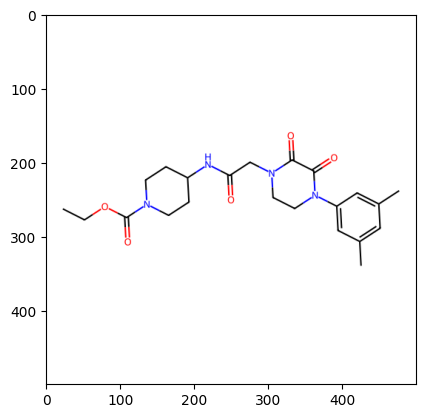

Cc1cc(C)cc(N2CCN(CC(=O)NC3CCCC3)C(=O)C2=O)c1


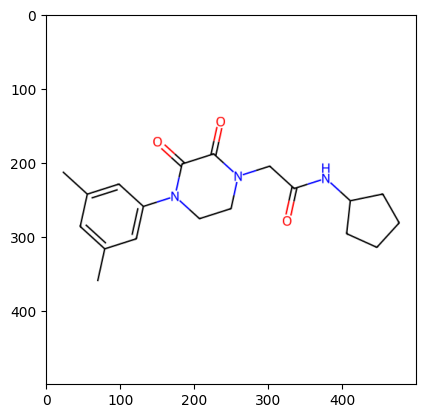

COc1ccc(N2CCN(CC(=O)Nc3cc(C)cc(C)c3)C(=O)C2=O)cc1OC


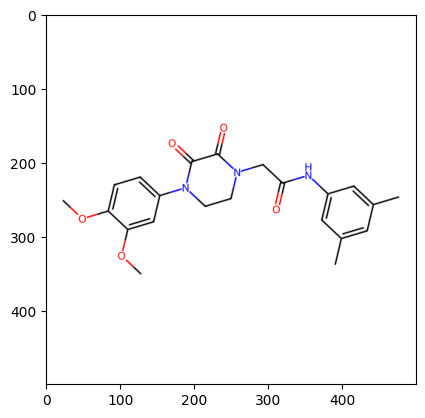

COc1ccc(N2CCN(CC(=O)Nc3ccc(C)cc3)C(=O)C2=O)cc1OC


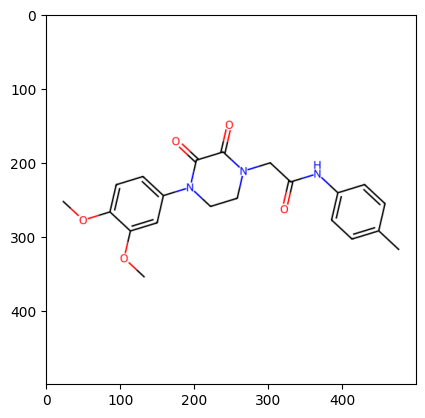

CCN1CCN(c2cc(C)cc(C)c2)C(=O)C1=O


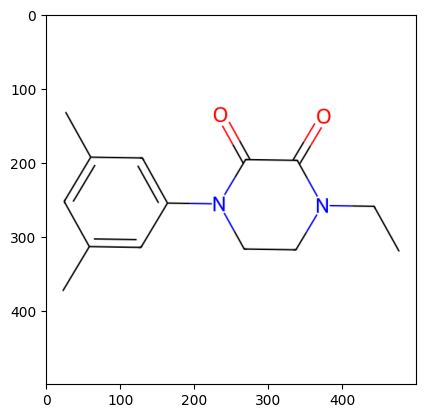

O=C(CN1CCN(c2cccc(Cl)c2)C(=O)C1=O)NC1CCCC1


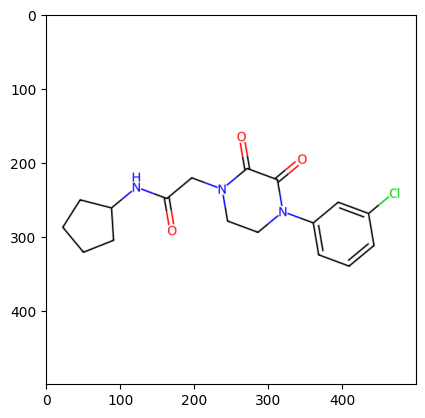

COc1ccc(N2CCN(Cc3ccc(C)cc3)C(=O)C2=O)cc1OC


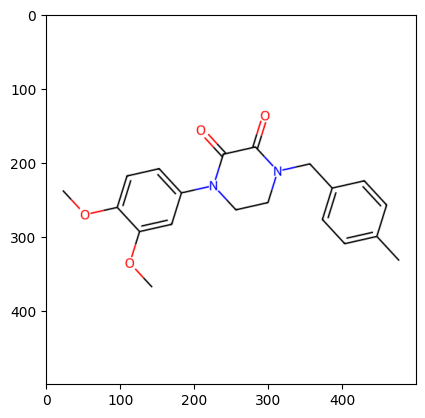

CCOC(=O)CN1CCN(C2CC2)C(=O)C1=O


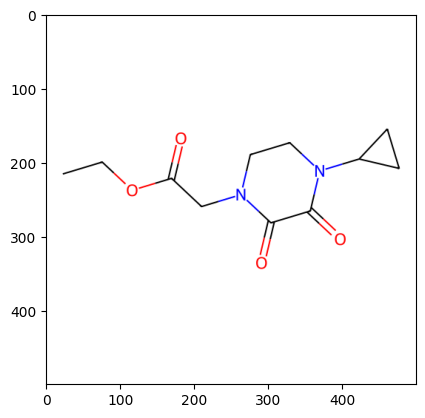

Cc1cc(C)cc(NC(=O)CN2CCN(c3ccc(F)c(F)c3)C(=O)C2=O)c1


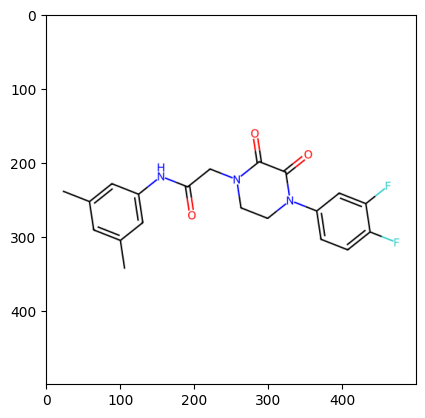

Cc1cc(C)cc(N2CCN(CC#N)C(=O)C2=O)c1


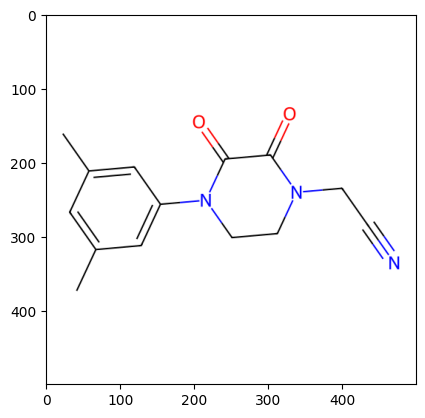

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>]

In [90]:
images = to_images(matchs)
images